Using device: mps
Output shape: torch.Size([32, 4])
Sample logits: tensor([-1.4730,  0.7084,  0.0068,  0.5955], device='mps:0',
       grad_fn=<SelectBackward0>)
Label shape: torch.Size([32])
Sample labels: tensor([1, 3, 2, 3, 3, 2, 3, 3, 3, 3], device='mps:0')
Unique labels in batch: tensor([0, 1, 2, 3], device='mps:0')
Epoch 1/10 - Loss: 24.6030, Train Acc: 0.6919, Val Acc: 0.6282, Val Loss: 0.6755
Epoch 2/10 - Loss: 11.9156, Train Acc: 0.8766, Val Acc: 0.6410, Val Loss: 0.9961
Epoch 3/10 - Loss: 6.5825, Train Acc: 0.9404, Val Acc: 0.6154, Val Loss: 1.2083
Epoch 4/10 - Loss: 5.9687, Train Acc: 0.9370, Val Acc: 0.7564, Val Loss: 0.6408
Epoch 5/10 - Loss: 2.7042, Train Acc: 0.9787, Val Acc: 0.6923, Val Loss: 0.7859
Epoch 6/10 - Loss: 1.8786, Train Acc: 0.9813, Val Acc: 0.7179, Val Loss: 0.7824
Epoch 7/10 - Loss: 2.0043, Train Acc: 0.9779, Val Acc: 0.7179, Val Loss: 1.0966
Epoch 8/10 - Loss: 2.0768, Train Acc: 0.9830, Val Acc: 0.7308, Val Loss: 0.9065
Epoch 9/10 - Loss: 0.6840, Train Ac

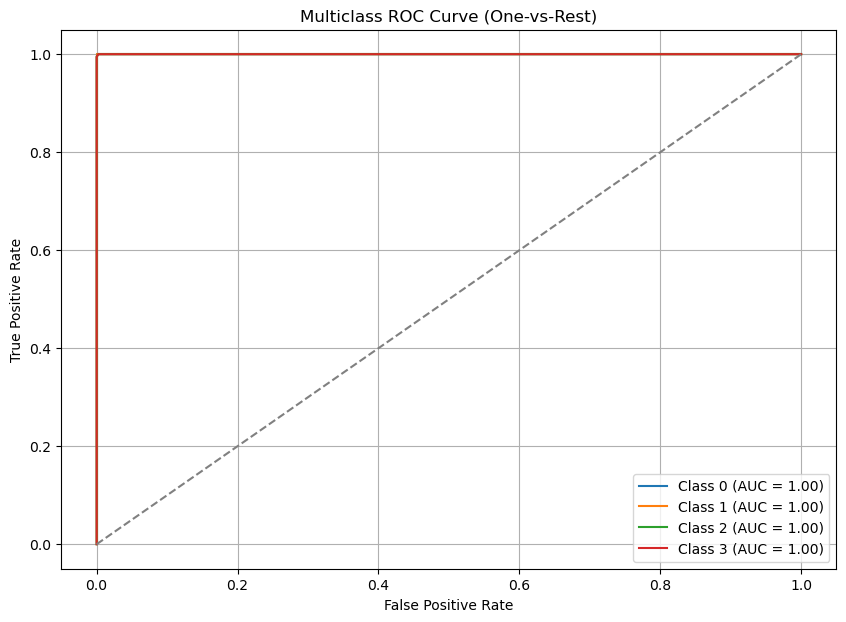

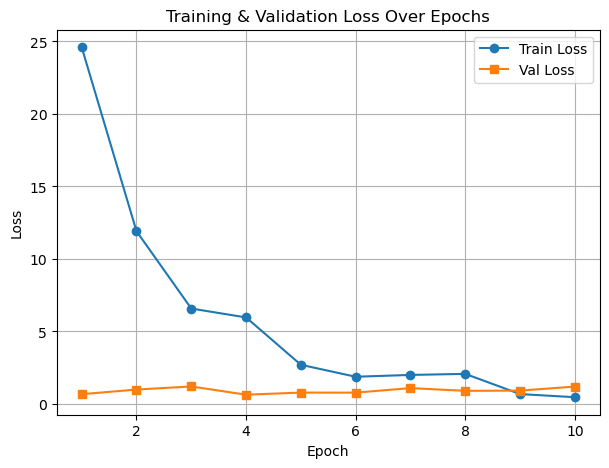

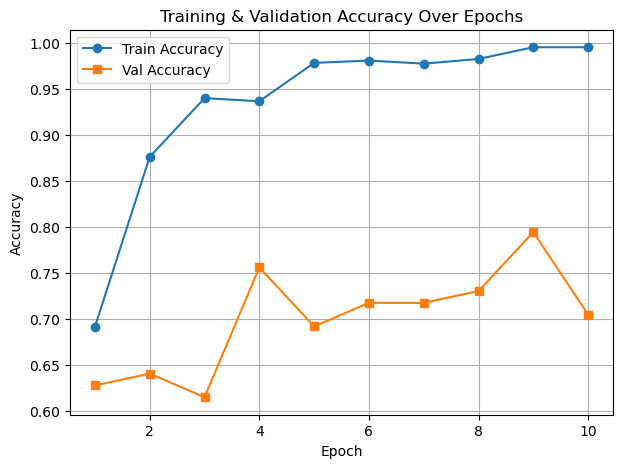

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from architectures.benchmark_ResNet18_multiclass import make_model  # Import ResNet18 model
from torch.utils.data.dataset import Subset
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load dataset splits safely
with torch.serialization.safe_globals([Subset]):
    train_set = torch.load("multiclass_dataset/image_datasets/train_set.pth", weights_only=False)
    val_set = torch.load("multiclass_dataset/image_datasets/val_set.pth", weights_only=False)
    test_set = torch.load("multiclass_dataset/image_datasets/test_set.pth", weights_only=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Set device (CUDA, MPS, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet18 model
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)

# Define loss function and optimizer (now Cross Entropy for multiclass)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# Track losses and accuracy for plots
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if epoch == 0 and batch_idx == 0:
                print("Output shape:", outputs.shape)
                print("Sample logits:", outputs[0])
                print("Label shape:", labels.shape)
                print("Sample labels:", labels[:10])
                print("Unique labels in batch:", labels.unique())

        train_acc = correct / total
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        train_losses.append(running_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        torch.save(model.state_dict(), "resNet18_multiclass.pth")


        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")


# Validation function


def validate_model(model, val_loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1) #changed from sigmoid to argmax

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, running_loss / len(val_loader)

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Function to find the best threshold using AUC-ROC
from sklearn.preprocessing import label_binarize

def find_best_threshold_multiclass(model, loader, n_classes=4):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    binarized_labels = label_binarize(all_labels, classes=list(range(n_classes)))

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(binarized_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve (One-vs-Rest)")
    plt.legend()
    plt.grid()
    plt.show()

find_best_threshold_multiclass(model, train_loader)


# Test function using best threshold
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total:.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(4)])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


# Plot Training & Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


# Assuming test_set is already loaded and 'model' is trained
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

model.eval()
correct_indices_by_class = {}  # {class_label: index}

with torch.no_grad():
    for idx, (image, label) in enumerate(test_loader):
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        pred = torch.argmax(output, dim=1)
        if pred == label:
            label_val = label.item()
            if label_val not in correct_indices_by_class:
                correct_indices_by_class[label_val] = idx
        if len(correct_indices_by_class) == 4:
            break

print("Correctly classified indices by class:", correct_indices_by_class)



# Load full dataset (original + augmented)
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

full_dataset = ImageFolder(root="/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass", transform=original_transform)

# Get original indices from the test split
test_indices = test_set.indices if hasattr(test_set, 'indices') else range(len(test_set))

# Map index to filepath
index_to_filename = {}
for class_name in full_dataset.classes:
    class_dir = os.path.join(full_dataset.root, class_name)
    for fname in sorted(os.listdir(class_dir)):  # sorted = matches ImageFolder
        index_to_filename[len(index_to_filename)] = os.path.join(class_dir, fname)

# Retrieve the filenames for the 4 correctly classified examples
for class_id, subset_idx in correct_indices_by_class.items():
    original_index = test_indices[subset_idx]
    filename = index_to_filename[original_index]
    print(f"Class {class_id} => File: {filename}")

    # Paths
data_dir = "/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass"
raw_dataset = ImageFolder(root=data_dir)

# Target indices (from your correct classifications)
target_indices = {
    3: 0,   # tumor_immunogenic
    1: 4,   # tumor_non_immunogenic
    0: 5,   # bacterial_non_immunogenic
    2: 9   # bacterial_immunogenic
}

# Reverse-map to raw_dataset
num_augmentations_per_image = 5
original_indices = {cls: idx // num_augmentations_per_image for cls, idx in target_indices.items()}

# Print original filenames
for cls, raw_idx in original_indices.items():
    original_path = raw_dataset.imgs[raw_idx][0]
    pdb_id = os.path.basename(original_path).replace(".pdb.png", "").replace(".png", "")
    print(f"Class {cls} came from original PDB: {pdb_id} (File: {original_path})")



Correctly classified indices by class: {3: 0, 1: 4, 0: 5, 2: 9}
Class 3 => File: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/tumor_non_immunogenic/AF-F8WDI9-F1.pdb.png
Class 1 => File: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/bacterial_non_immunogenic/AF_REMOTE_AF-P44831-F1.png
Class 0 => File: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/bacterial_immunogenic/AF_REMOTE_AF-P9WG27-F1.png
Class 2 => File: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/tumor_immunogenic/4z18.pdb.png
Class 3 came from original PDB: 1djr (File: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/bacterial_immunogenic/1djr.p

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset
from architectures.benchmark_ResNet18_multiclass import make_model

# Paths
base_dir = "/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project"
original_dataset_path = os.path.join(base_dir, "multiclass_dataset/multiclass")
test_set_path = os.path.join(base_dir, "multiclass_dataset/image_datasets/test_set.pth")
model_path = "resnet18_multiclass.pth"  # if saved

original_dataset_size = len(ImageFolder(root=original_dataset_path))


# Transforms (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])
# Load unaugmented dataset
original_dataset = ImageFolder(root=original_dataset_path, transform=transform)
full_dataset_path = os.path.join(base_dir, "multiclass_dataset/multiclass")
full_dataset = ImageFolder(root=full_dataset_path, transform=transform)

# Load test set
from torch.serialization import safe_globals
with safe_globals([Subset]):
    test_set = torch.load(test_set_path, weights_only=False)

test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Load model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)
model.load_state_dict(torch.load(model_path))  # This line correctly loads the weights

model.load_state_dict(torch.load(model_path))
model.eval()

# Track correctly predicted unaugmented samples
# Track correctly predicted unaugmented samples based on TRUE class
class_to_correct_index = {}
with torch.no_grad():
    for subset_idx, (img, label) in enumerate(test_set):
        original_idx = test_set.indices[subset_idx]  # map to full_dataset
        if original_idx >= original_dataset_size:
            continue  # skip augmented images

        input_img = img.unsqueeze(0).to(device)
        pred = model(input_img).argmax(dim=1).item()
        true_label = label

        if pred == true_label and true_label not in class_to_correct_index:
            class_to_correct_index[true_label] = original_idx

        if len(class_to_correct_index) == 4:
            break


# Output results
for cls_idx, original_idx in class_to_correct_index.items():
    img_path, label = full_dataset.imgs[original_idx]
    class_name = full_dataset.classes[label]
    print(f"Class {cls_idx} (Correctly classified): {img_path} | Class name: {class_name}")



/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcobenavides/miniforge3/envs/ML4FG/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class 3 (Correctly classified): /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/tumor_non_immunogenic/AF-F8WDI9-F1.pdb.png | Class name: tumor_non_immunogenic
Class 1 (Correctly classified): /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/bacterial_non_immunogenic/AF_REMOTE_AF-P44831-F1.png | Class name: bacterial_non_immunogenic
Class 0 (Correctly classified): /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/bacterial_immunogenic/AF_REMOTE_AF-P9WG27-F1.png | Class name: bacterial_immunogenic
Class 2 (Correctly classified): /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/tumor_immunogenic/4z18.pdb.png | Class name: tumor_immunogenic


In [ ]:
import os
import py3Dmol
from IPython.display import display, HTML

def find_pdb_file(base_path, pdb_id):
    """Recursively search for .pdb file that contains the pdb_id (even if prefixed)."""
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if pdb_id.lower() in file.lower() and file.endswith(".pdb"):
                return os.path.join(root, file)
    return None


def get_image_path(image_base_dir, class_name, pdb_id):
    """Search for image file that contains the pdb_id inside its name."""
    class_path = os.path.join(image_base_dir, class_name)
    if not os.path.exists(class_path):
        return None
    for file in os.listdir(class_path):
        if pdb_id.lower() in file.lower() and file.endswith(".png"):
            return os.path.join(class_path, file)
    return None


def show_structure_and_image(pdb_path, image_path, class_name):
    """Visualize 3D PDB structure + Voronoi image side-by-side."""
    with open(pdb_path, 'r') as f:
        pdb_data = f.read()

    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_data, "pdb")
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.setBackgroundColor('white')
    view.zoomTo()
    
    print(f"\nDisplaying: {class_name} — {os.path.basename(pdb_path)}")
    
    html = f"""
    <div style="display: flex; gap: 30px; margin-bottom: 30px;">
        <div>{view._make_html()}</div>
        <div>
            <img src="file://{image_path}" width="400" height="400" alt="{class_name} image"/>
            <p style="text-align: center;">Voronoi Image for <b>{class_name}</b></p>
        </div>
    </div>
    """
    display(HTML(html))

# Paths
base_dir = "/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project"
image_dir = os.path.join(base_dir, "multiclass_dataset/multiclass")

# Class map: index → (pdb_id, class_name)
class_pdb_map = {
    0: ("AF-P9WG27-F1","bacterial_immunogenic"),
    1: ("AF-P44831-F1", "bacterial_non_immunogenic"),
    2: ("4z18", "tumor_immunogenic"),
    3: ("AF-F8WDI9-F1", "tumor_non_immunogenic")
}

# Display each protein
for class_idx, (pdb_id, class_name) in class_pdb_map.items():
    pdb_path = find_pdb_file(base_dir, pdb_id)
    image_path = get_image_path(image_dir, class_name,pdb_id)
    
    image_path = get_image_path(image_dir, class_name, pdb_id)
        
    if pdb_path and image_path:
        print(f"Class {class_idx} ({class_name}): Found PDB and image")
        show_structure_and_image(pdb_path, image_path, class_name)
    else:
        print(f"Class {class_idx} ({class_name}): Missing file(s)")
        if not pdb_path:
            print(f"   - PDB not found: {pdb_id}")
        if not image_path:
            print(f"   - Image not found: {pdb_id}.pdb.png or {pdb_id}.png")



Class 0 (bacterial_immunogenic): Found PDB and image

🧬 Displaying: bacterial_immunogenic — AF-P9WG27-F1.pdb


Class 1 (bacterial_non_immunogenic): Found PDB and image

🧬 Displaying: bacterial_non_immunogenic — AF-P44831-F1.pdb


Class 2 (tumor_immunogenic): Found PDB and image

🧬 Displaying: tumor_immunogenic — 4z18.pdb


Class 3 (tumor_non_immunogenic): Found PDB and image

🧬 Displaying: tumor_non_immunogenic — AF-F8WDI9-F1.pdb


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import cv2
from matplotlib import cm
from architectures.benchmark_ResNet18_multiclass import make_model

# === Set paths ===
base_dir = "/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project"
data_path = os.path.join(base_dir, "multiclass_dataset/multiclass")
model_path = os.path.join(base_dir, "resnet18_multiclass.pth")

# === Define the class to PDB and class name mapping ===
class_pdb_map = {
    0: ("AF-P9WG27-F1", "bacterial_immunogenic"),
    1: ("AF-P44831-F1", "bacterial_non_immunogenic"),
    2: ("4z18", "tumor_immunogenic"),
    3: ("AF-F8WDI9-F1", "tumor_non_immunogenic")
}

# === Image transform (same as training) ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# === Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# === Overlay function ===
def overlay_saliency_on_voronoi(voronoi_path, saliency, save_path, cmap_name="magma"):
    voronoi = cv2.imread(voronoi_path)
    gray_voronoi = cv2.cvtColor(voronoi, cv2.COLOR_BGR2GRAY)
    gray_voronoi = gray_voronoi.astype(np.float32) / 255.0
    dimmed_voronoi = np.stack([gray_voronoi]*3, axis=-1) * 0.5

    saliency_resized = cv2.resize(saliency, (gray_voronoi.shape[1], gray_voronoi.shape[0]))
    saliency_norm = (saliency_resized - saliency_resized.min()) / (saliency_resized.max() - saliency_resized.min() + 1e-8)

    cmap = cm.get_cmap(cmap_name)
    saliency_colored = cmap(saliency_norm)[..., :3]

    alpha_mask = np.clip(saliency_norm * 1.5, 0, 1)
    overlay = dimmed_voronoi * (1 - alpha_mask[..., None]) + saliency_colored * alpha_mask[..., None]
    overlay = np.clip(overlay, 0, 1)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(overlay)
    ax.axis('off')
    cbar = plt.colorbar(cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap_name),
                        ax=ax, shrink=0.9)
    cbar.set_label("Saliency Intensity", fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved saliency overlay: {save_path}")

# === Main logic using class_pdb_map ===
for class_idx, (pdb_id, class_name) in class_pdb_map.items():
    # Find corresponding Voronoi image
    class_dir = os.path.join(data_path, class_name)
    voronoi_file = next((f for f in os.listdir(class_dir) if pdb_id.lower() in f.lower() and f.endswith(".png")), None)
    
    if not voronoi_file:
        print(f"[SKIP] Voronoi image not found for class {class_name} (PDB: {pdb_id})")
        continue

    voronoi_path = os.path.join(class_dir, voronoi_file)
    
    # Load image and preprocess
    img_pil = Image.open(voronoi_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device).requires_grad_()

    # Forward pass
    output = model(img_tensor)
    pred_label = output.argmax(dim=1).item()

    # Only compute saliency if correctly predicted
    if pred_label == class_idx:
        output[0, pred_label].backward()
        saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)
        saliency_np = saliency.squeeze().cpu().numpy()

        # Save path
        save_name = os.path.splitext(voronoi_file)[0] + "_saliency_overlay.png"
        save_path = os.path.join(class_dir, save_name)

        overlay_saliency_on_voronoi(voronoi_path, saliency_np, save_path)
    else:
        print(f"[SKIP] Model misclassified {pdb_id}: predicted {pred_label}, expected {class_idx}")


/var/folders/z6/vlplg73s0cbgpvtzthyjl34h0000gn/T/ipykernel_38004/120938605.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Saved saliency overlay: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/bacterial_immunogenic/AF_REMOTE_AF-P9WG27-F1_saliency_overlay.png
[SKIP] Model misclassified AF-P44831-F1: predicted 3, expected 1
Saved saliency overlay: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/tumor_immunogenic/4z18.pdb_saliency_overlay.png
Saved saliency overlay: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/tumor_non_immunogenic/AF-F8WDI9-F1.pdb_saliency_overlay.png


In [ ]:
import os
import json
import numpy as np
from scipy.spatial import Voronoi
from Bio import PDB

# === Reuse this function from your first script ===
def find_pdb_file(base_path, pdb_id):
    for root, _, files in os.walk(base_path):
        for file in files:
            if pdb_id.lower() in file.lower() and file.endswith(".pdb"):
                return os.path.join(root, file)
    return None

# === Extract CA coordinates and residue types ===
def extract_residue_coordinates_and_types(pdb_file):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)

    coords, types = [], []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    coords.append(residue["CA"].coord)
                    types.append(residue.get_resname())
    return np.array(coords), types

# === Generate and save 2D Voronoi-3D mapping ===
def generate_voronoi_3d_mapping(pdb_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    coords_3d, residue_types = extract_residue_coordinates_and_types(pdb_path)
    if len(coords_3d) < 2:
        raise ValueError(f"Not enough residues in {pdb_path} for Voronoi.")

    coords_2d = coords_3d[:, :2]
    vor = Voronoi(coords_2d)

    mapping = {}
    for i, (coord2d, coord3d, res_type) in enumerate(zip(coords_2d, coords_3d, residue_types)):
        mapping[i] = {
            "residue_2d": coord2d.tolist(),
            "residue_3d": coord3d.tolist(),
            "residue_type": res_type
        }

    filename = os.path.splitext(os.path.basename(pdb_path))[0]
    json_path = os.path.join(output_folder, f"{filename}_mapping.json")
    with open(json_path, 'w') as f:
        json.dump(mapping, f, indent=2)
    
    print(f"Saved mapping: {json_path}")
    return json_path

# === Use your class_pdb_map from the first script ===
class_pdb_map = {
    0: ("AF-P9WG27-F1", "bacterial_immunogenic"),
    1: ("AF-P44831-F1", "bacterial_non_immunogenic"),
    2: ("4z18", "tumor_immunogenic"),
    3: ("AF-F8WDI9-F1", "tumor_non_immunogenic")
}

# === Main run ===
project_root = "/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project"
output_folder = os.path.join(project_root, "output_folder")

for class_idx, (pdb_id, class_name) in class_pdb_map.items():
    pdb_path = find_pdb_file(project_root, pdb_id)
    if pdb_path is None:
        print(f"PDB not found for {pdb_id} in class {class_name}")
        continue

    base = os.path.splitext(os.path.basename(pdb_path))[0]
    mapping_json_path = os.path.join(output_folder, f"{base}_mapping.json")
    
    if not os.path.exists(mapping_json_path):
        try:
            generate_voronoi_3d_mapping(pdb_path, output_folder)
        except Exception as e:
            print(f"Error processing {pdb_path}: {e}")
    else:
        print(f"✔ Mapping already exists: {mapping_json_path}")


✔ Mapping already exists: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/output_folder/AF-P9WG27-F1_mapping.json
✔ Mapping already exists: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/output_folder/AF-P44831-F1_mapping.json
✔ Mapping already exists: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/output_folder/4z18_mapping.json
✔ Mapping already exists: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/output_folder/AF-F8WDI9-F1_mapping.json


In [ ]:
import os
import json
import numpy as np
from scipy.spatial import Voronoi
from Bio import PDB
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cv2
import py3Dmol
import torch
from torchvision import transforms
from PIL import Image
from architectures.benchmark_ResNet18_multiclass import make_model

def find_file_globally(root_dir, partial_name, extension):
    for dirpath, _, files in os.walk(root_dir):
        for f in files:
            if partial_name.lower() in f.lower() and f.endswith(extension):
                return os.path.join(dirpath, f)
    raise FileNotFoundError(f"{partial_name}{extension} not found under {root_dir}")

def extract_residue_coordinates_and_types(pdb_file):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords, types = [], []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    coords.append(residue["CA"].coord)
                    types.append(residue.get_resname())
    return np.array(coords), types

def generate_voronoi_3d_mapping(pdb_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    coords_3d, residue_types = extract_residue_coordinates_and_types(pdb_path)
    if len(coords_3d) < 2:
        raise ValueError(f"Not enough residues in {pdb_path} for Voronoi.")

    coords_2d = coords_3d[:, :2]
    vor = Voronoi(coords_2d)

    mapping = {
        i: {
            "residue_2d": coord2d.tolist(),
            "residue_3d": coord3d.tolist(),
            "residue_type": res_type
        }
        for i, (coord2d, coord3d, res_type) in enumerate(zip(coords_2d, coords_3d, residue_types))
    }

    filename = os.path.splitext(os.path.basename(pdb_path))[0]
    json_path = os.path.join(output_folder, f"{filename}_mapping.json")
    with open(json_path, 'w') as f:
        json.dump(mapping, f, indent=2)
    print(f"Saved mapping: {json_path}")
    return json_path

def export_saliency_outputs(saliency_np, voronoi_path, output_dir, base_name, cmap_name="cividis"):
    os.makedirs(output_dir, exist_ok=True)
    voronoi_img = cv2.imread(voronoi_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    voronoi_img = np.stack([voronoi_img]*3, axis=-1) * 0.5

    saliency_resized = cv2.resize(saliency_np, (voronoi_img.shape[1], voronoi_img.shape[0]))
    p1, p99 = np.percentile(saliency_resized, [1, 99])
    saliency_clipped = np.clip(saliency_resized, p1, p99)
    saliency_norm = (saliency_clipped - p1) / (p99 - p1 + 1e-8)
    saliency_norm = np.power(saliency_norm, 0.7)

    np.save(os.path.join(output_dir, f"{base_name}_saliency_raw.npy"), saliency_norm)

    cmap = cm.get_cmap(cmap_name)
    saliency_colored = cmap(saliency_norm)[..., :3]
    alpha = np.clip(saliency_norm * 1.5, 0, 1)
    overlay = voronoi_img * (1 - alpha[..., None]) + saliency_colored * alpha[..., None]
    overlay = np.clip(overlay, 0, 1)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(overlay)
    ax.axis('off')
    cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(0, 1), cmap=cmap), ax=ax, shrink=0.8)
    cbar.set_label("Saliency Intensity", fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{base_name}_overlay_saliency.png"), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved overlay image: {os.path.join(output_dir, f'{base_name}_overlay_saliency.png')}")
    return saliency_norm

def render_original_only(pdb_path, output_folder):
    view = py3Dmol.view(width=700, height=600)
    with open(pdb_path, 'r') as f:
        pdb_data = f.read()
    view.addModel(pdb_data, "pdb")
    view.setStyle({'cartoon': {'color': 'white'}})
    view.setBackgroundColor('black')
    view.zoomTo()
    view.spin(True)
    view.show()
    view.render()
    base = os.path.basename(pdb_path).split('.')[0]
    view.write_html(os.path.join(output_folder, f"{base}_original.html"))


def render_saliency_only(pdb_path, mapping_json, saliency_norm, output_folder, base_name):
    with open(mapping_json, 'r') as f:
        mapping = json.load(f)

    view = py3Dmol.view(width=700, height=600)
    with open(pdb_path, 'r') as f:
        view.addModel(f.read(), "pdb")
    view.setStyle({'cartoon': {'color': 'white'}})
    view.setBackgroundColor('black')

    for _, info in mapping.items():
        x2d, y2d = map(int, info["residue_2d"])
        x3d, y3d, z3d = info["residue_3d"]
        if 0 <= y2d < saliency_norm.shape[0] and 0 <= x2d < saliency_norm.shape[1]:
            norm_intensity = saliency_norm[y2d, x2d]
            rgba = cm.magma(norm_intensity)
            hex_color = "#{:02x}{:02x}{:02x}".format(
                int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255)
            )
            view.addSphere({
                "center": {"x": x3d, "y": y3d, "z": z3d},
                "radius": 0.8,
                "color": hex_color
            })

    view.zoomTo()
    view.spin(True)
    view.show()
    view.render()
    view.write_html(os.path.join(output_folder, f"{base_name}_saliency.html"))

def render_side_by_side_saliency_and_original(pdb_path, mapping_json, saliency_norm):
    with open(mapping_json, 'r') as f:
        mapping = json.load(f)

    view = py3Dmol.view(width=1400, height=600)
    with open(pdb_path, 'r') as f:
        pdb_data = f.read()

    # === Original structure on left (viewer 0) ===
    view.addModel(pdb_data, "pdb", viewer=(0,))
    view.setStyle({'cartoon': {'color': 'white'}}, viewer=(0,))
    view.zoomTo(viewer=(0,))

    # === Saliency-mapped structure on right (viewer 1) ===
    view.addModel(pdb_data, "pdb", viewer=(1,))
    view.setStyle({'cartoon': {'color': 'white'}}, viewer=(1,))
    for _, info in mapping.items():
        x2d, y2d = map(int, info["residue_2d"])
        x3d, y3d, z3d = info["residue_3d"]
        if 0 <= y2d < saliency_norm.shape[0] and 0 <= x2d < saliency_norm.shape[1]:
            norm_intensity = saliency_norm[y2d, x2d]
            rgba = cm.magma(norm_intensity)
            hex_color = "#{:02x}{:02x}{:02x}".format(
                int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255)
            )
            view.addSphere({
                "center": {"x": x3d, "y": y3d, "z": z3d},
                "radius": 0.8,
                "color": hex_color
            }, viewer=(1,))
    view.zoomTo(viewer=(1,))
    view.setLayout('horizontal')
    view.show()
    view.render()
    view.write_html(os.path.join(output_folder, f"{os.path.basename(pdb_path).split('.')[0]}_saliency_vs_original.html"))



# === Configuration ===
project_root = "/Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project"
data_path = os.path.join(project_root, "multiclass_dataset/multiclass")
output_folder = os.path.join(project_root, "output_folder")

class_pdb_map = {
    0: ("AF-P9WG27-F1", "bacterial_immunogenic"),
    1: ("AF-P44831-F1", "bacterial_non_immunogenic"),
    2: ("4z18", "tumor_immunogenic"),
    3: ("AF-F8WDI9-F1", "tumor_non_immunogenic")
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = make_model("resnet18", feature_extracting=False, use_pretrained=True).to(device)
model.load_state_dict(torch.load(os.path.join(project_root, "resnet18_multiclass.pth")))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# === Main loop ===
for class_idx, (pdb_id, class_name) in class_pdb_map.items():
    print(f"\n▶ Processing: {pdb_id} ({class_name})")

    try:
        img_path = find_file_globally(data_path, pdb_id, ".png")
        pdb_path = find_file_globally(project_root, pdb_id, ".pdb")
    except FileNotFoundError as e:
        print(f"Missing file: {e}")
        continue

    voronoi_path = img_path
    output_dir = os.path.dirname(img_path)
    mapping_path = os.path.join(output_folder, f"{pdb_id}_mapping.json")

    if not os.path.exists(mapping_path):
        try:
            generate_voronoi_3d_mapping(pdb_path, output_folder)
        except Exception as e:
            print(f"Error generating mapping for {pdb_id}: {e}")
            continue

    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device).requires_grad_()
    output = model(img_tensor)
    pred = output.argmax(dim=1).item()
    output[0, pred].backward()
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)
    saliency_np = saliency.squeeze().cpu().numpy()

    saliency_norm = export_saliency_outputs(saliency_np, voronoi_path, output_dir, pdb_id)

    # Call this function to render both models side by side and export HTML
    render_original_only(pdb_path, output_folder)
    render_saliency_only(pdb_path, mapping_path, saliency_norm, output_folder, pdb_id)






▶ Processing: AF-P9WG27-F1 (bacterial_immunogenic)


/var/folders/z6/vlplg73s0cbgpvtzthyjl34h0000gn/T/ipykernel_38004/1266100646.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


✅ Saved overlay image: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/bacterial_immunogenic/AF-P9WG27-F1_overlay_saliency.png


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


▶ Processing: AF-P44831-F1 (bacterial_non_immunogenic)
✅ Saved overlay image: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/bacterial_non_immunogenic/AF-P44831-F1_overlay_saliency.png


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


▶ Processing: 4z18 (tumor_immunogenic)
✅ Saved overlay image: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/tumor_immunogenic/4z18_overlay_saliency.png


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


▶ Processing: AF-F8WDI9-F1 (tumor_non_immunogenic)
✅ Saved overlay image: /Users/marcobenavides/Documents/Columbia University/Spring 2025/DL Biomedical Imaging/Project/multiclass_dataset/multiclass/tumor_non_immunogenic/AF-F8WDI9-F1_overlay_saliency.png


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

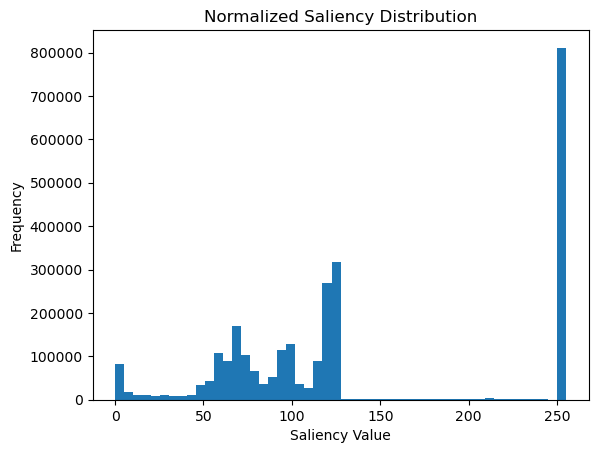

In [111]:
plt.hist(saliency_resized.flatten(), bins=50)
plt.title("Normalized Saliency Distribution")
plt.xlabel("Saliency Value")
plt.ylabel("Frequency")
plt.show()
